# Project 1 – Decision Trees and Random Forests

In [26]:
# Reload all modules without having to restart the kernel
# Useful for development if you have edited any of the external code files.
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# My implementations
from decision_tree import DecisionTree
from random_forest import RandomForest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

Do data loading, exploration and preprocessing as you see fit.

Here is some code to load the dataset to get you started.

In [27]:
data = np.genfromtxt("wine_dataset_small.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['citric_acid', 'residual_sugar', 'pH', 'sulphates', 'alcohol']
Target column name: type
X shape: (500, 5)
y shape: (500,)


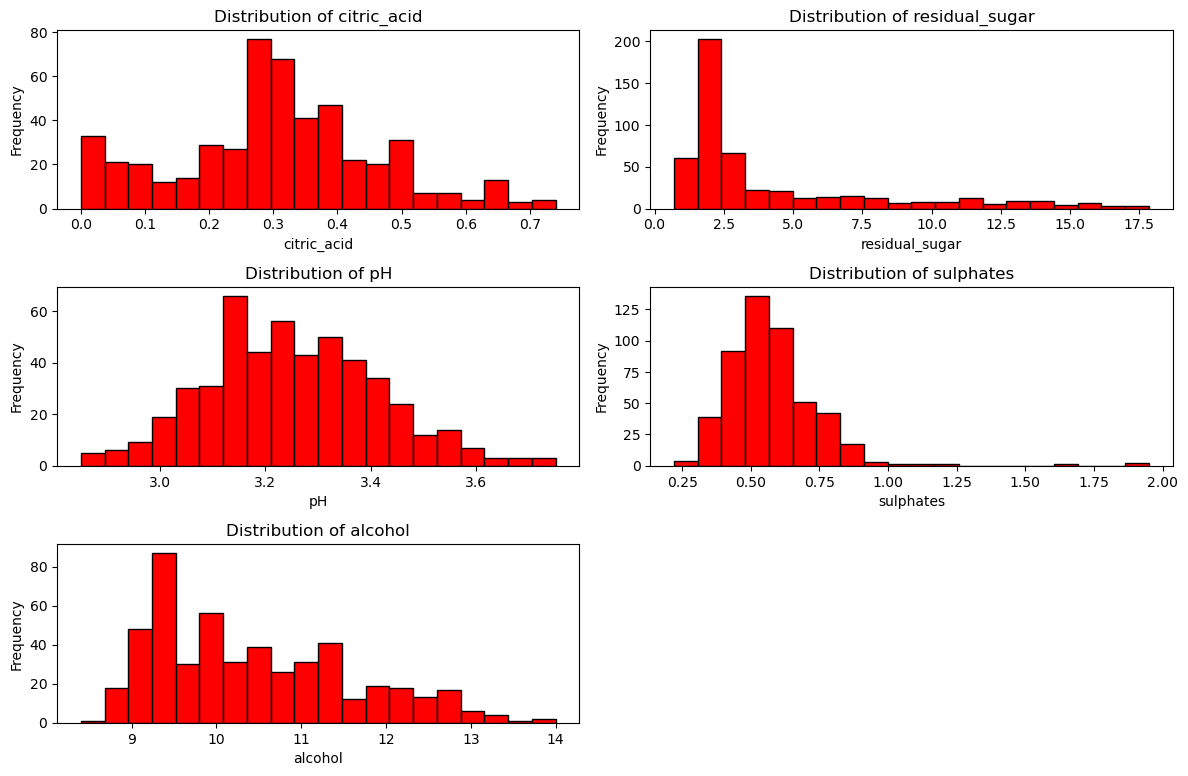

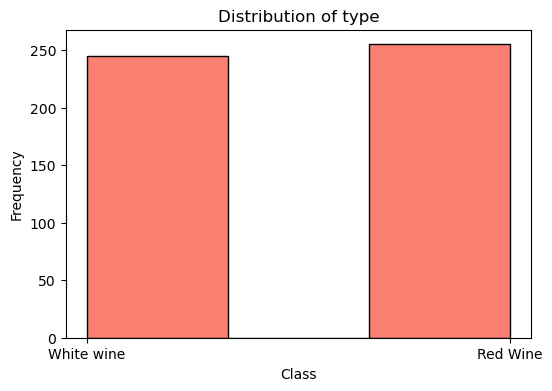

In [28]:
# Here is a visualization of the wine data

# Show the distribution of the features:
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(4, 2, i+1) 
    plt.hist(X[:, i], bins=20, color='red', edgecolor='black')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Show the distribution of the targets:
plt.figure(figsize=(6, 4))
plt.hist(y, bins=3, color='salmon', edgecolor='black')
plt.title(f"Distribution of {target_name}")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["White wine", "Red Wine"])
plt.show()

In [29]:
# Set seed 
seed = 0
np.random.seed(seed)


#Split the data into test and (training and validation)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True)

# Use k fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [30]:
# Lists of hyperparameters that i want to tune
max_depth_params = [3,10,15,20,None]

n_estimators = [2,10,15,30]

criterion = ["gini", "entropy"]

max_features = ["sqrt", "log2", None]


In [31]:
# Function for tuning random forest using k-fold cross validation

def tune_random_forest(model_type, X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf):
    best_accuracy = [0]  # To store the best average accuracy and the hyperparameters
    
    # Iterate through all combinations of hyperparameters
    for maxdp in max_depth_params:
        for n_est in n_estimators:
            for crit in criterion:
                for mf in max_features:
                    
                    # Init the model
                    if model_type == "RandomForest":
                        rf = RandomForest(n_estimators=n_est, max_depth=maxdp, criterion=crit, max_features=mf, seed=seed)
                    elif model_type == "SklearnRandomForest":
                        rf = RandomForestClassifier(n_estimators=n_est, max_depth=maxdp, criterion=crit, max_features=mf , random_state=seed)
                    else:
                        raise ValueError("Invalid model_type. Choose either 'RandomForest' or 'SklearnRandomForest'.")
                    
                    # List to store accuracies for each fold in the k-fold cross validation
                    fold_accuracies = []
                    
                    # k-fold cross-validation
                    for train_index, val_index in kf.split(X_train_val):
                        # Split the data into training and validation sets for each fold
                        X_training, X_val = X_train_val[train_index], X_train_val[val_index]
                        y_training, y_val = y_train_val[train_index], y_train_val[val_index]
                        
                        # Fit random forest on the training data
                        rf.fit(X_training, y_training)
                        
                        # Predict validation
                        y_pred = rf.predict(X_val)
                        
                        # Calculate accuracy for the current fold
                        accuracy = accuracy_score(y_val, y_pred)
                        fold_accuracies.append(accuracy)
                    
                    # Calculate average accuracy across all folds
                    average_accuracy = np.mean(fold_accuracies)
                    
                    # If current average is better then update the best average accuracy
                    if average_accuracy > best_accuracy[0]:
                        best_accuracy = [average_accuracy, n_est, maxdp, crit, mf]
    
    # Return the best hyperparameters and accuracy
    return best_accuracy

In [32]:
# Function for tuning decision tree using k-fold cross validation

def tune_decision_tree(model_type, X_train_val, y_train_val, max_depth_params, criterion, max_features, kf):
    best_accuracy = [0]  # To store the best average accuracy and the corresponding hyperparameters
    
    # Iterate through all combinations of hyperparameters
    for maxdp in max_depth_params:
            for crit in criterion:
                for mf in max_features:
                    
                    # Init the model
                    if model_type == "DecisionTree":
                        rf = DecisionTree(max_depth=maxdp, criterion=crit, max_features=mf, seed=seed)
                    elif model_type == "SklearnDecisionTree":
                        rf = DecisionTreeClassifier(max_depth=maxdp, criterion=crit, max_features=mf , random_state=seed)
                    else:
                        raise ValueError("Invalid model_type. Choose either 'RandomForest' or 'SklearnRandomForest'.")
                    
                    # List to store accuracies for each fold
                    fold_accuracies = []
                    
                    # k-fold cross-validation
                    for train_index, val_index in kf.split(X_train_val):
                        # Split the data into training and validation sets for each fold
                        X_training, X_val = X_train_val[train_index], X_train_val[val_index]
                        y_training, y_val = y_train_val[train_index], y_train_val[val_index]
                        
                        # fit on training data
                        rf.fit(X_training, y_training)
                        
                        # Predict validation 
                        y_pred = rf.predict(X_val)
                        
                        # Calculate accuracy for the current fold
                        accuracy = accuracy_score(y_val, y_pred)
                        fold_accuracies.append(accuracy)
                    
                    # Calculate average accuracy across all folds
                    average_accuracy = np.mean(fold_accuracies)
                    
                    # If current average is better then update the best average accuracy
                    if average_accuracy > best_accuracy[0]:
                        best_accuracy = [average_accuracy, maxdp, crit, mf]
    
    # Return the best hyperparameters and accuracy
    return best_accuracy

## Tuning and testing my decision tree classifier

In [33]:
# Find best values for hyperparameters for my own decision tree classifier
best_hyperparameters_for_decisionTree = tune_decision_tree("DecisionTree", X_train_val, y_train_val, max_depth_params, criterion, max_features, kf)

print(best_hyperparameters_for_decisionTree)

print(f"The best average accuracy is {best_hyperparameters_for_decisionTree[0]} with Max_depth: {best_hyperparameters_for_decisionTree[1]}, Criterion: {best_hyperparameters_for_decisionTree[2]}, Max_features: {best_hyperparameters_for_decisionTree[3]}.\n")

[np.float64(0.7885714285714285), 10, 'gini', None]
The best average accuracy is 0.7885714285714285 with Max_depth: 10, Criterion: gini, Max_features: None.



In [34]:
# Testing my DecisionTree with the the hyperparameters
rf = DecisionTree(max_depth=best_hyperparameters_for_decisionTree[1], criterion=best_hyperparameters_for_decisionTree[2], max_features=best_hyperparameters_for_decisionTree[3], seed=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")



Training and validation accuracy: 0.9942857142857143
Test accuracy: 0.76


## Tuning and testing sklearn decision tree classifier

In [35]:
# Find best values for hyperparameters for sklearn decision tree classifier
best_hyperparameters_for_decisionTree_sklearn = tune_decision_tree("SklearnDecisionTree", X_train_val, y_train_val, max_depth_params, criterion, max_features, kf)

print(best_hyperparameters_for_decisionTree_sklearn)

print(f"The best average accuracy is {best_hyperparameters_for_decisionTree_sklearn[0]} with Max_depth: {best_hyperparameters_for_decisionTree_sklearn[1]}, Criterion: {best_hyperparameters_for_decisionTree_sklearn[2]}, Max_features: {best_hyperparameters_for_decisionTree_sklearn[3]}.\n")

[np.float64(0.8285714285714286), 10, 'gini', None]
The best average accuracy is 0.8285714285714286 with Max_depth: 10, Criterion: gini, Max_features: None.



In [36]:
# Testing sklearn decision tree with the the hyperparameters
rf = DecisionTreeClassifier(max_depth=best_hyperparameters_for_decisionTree_sklearn[1], criterion=best_hyperparameters_for_decisionTree_sklearn[2], max_features=best_hyperparameters_for_decisionTree_sklearn[3], random_state=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9857142857142858
Test accuracy: 0.84


## Tuning and testing my random forest classifier

In [37]:
# Find best values for hyperparameters for my own random forest classifier

best_hypermeters_random_forest = tune_random_forest("RandomForest",X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf)


print(best_hypermeters_random_forest)

print(f"The best average accuracy is {best_hypermeters_random_forest[0]} with N_estimators: {best_hypermeters_random_forest[1]}, Max_depth: {best_hypermeters_random_forest[2]}, Criterion: {best_hypermeters_random_forest[3]}, Max_features: {best_hypermeters_random_forest[4]}.\n")


[np.float64(0.8914285714285715), 2, 10, 'entropy', None]
The best average accuracy is 0.8914285714285715 with N_estimators: 2, Max_depth: 10, Criterion: entropy, Max_features: None.



In [38]:
# Testing the hyperparameters on test set with my own random forest classifier
rf = RandomForest(n_estimators=best_hypermeters_random_forest[1], max_depth=best_hypermeters_random_forest[2], criterion=best_hypermeters_random_forest[3], max_features=best_hypermeters_random_forest[4], seed=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9228571428571428
Test accuracy: 0.8


## Tuning and testing sklearn random forest classifier

In [39]:
# Find best values for hyperparameters for sklearn random forest classifier
best_hypermeters_random_forest_sklearn = tune_random_forest("SklearnRandomForest",X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf)

print(best_hypermeters_random_forest_sklearn)

print(f"The best average accuracy is {best_hypermeters_random_forest_sklearn[0]} with N_estimators: {best_hypermeters_random_forest_sklearn [1]}, Max_depth: {best_hypermeters_random_forest_sklearn [2]}, Criterion: {best_hypermeters_random_forest_sklearn [3]}, Max_features: {best_hypermeters_random_forest_sklearn [4]}.\n")



[np.float64(0.8742857142857143), 30, 10, 'gini', 'sqrt']
The best average accuracy is 0.8742857142857143 with N_estimators: 30, Max_depth: 10, Criterion: gini, Max_features: sqrt.



In [40]:
# Testing the hyperparameters on test set
rf = RandomForestClassifier(n_estimators=best_hypermeters_random_forest_sklearn[1], max_depth=best_hypermeters_random_forest_sklearn[2], criterion=best_hypermeters_random_forest_sklearn[3], max_features=best_hypermeters_random_forest_sklearn[4], random_state=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9942857142857143
Test accuracy: 0.8866666666666667


## Comparing my decision tree vs sklearn decision tree:

In [41]:
# My own decision tree:
rf = DecisionTree(max_depth=best_hyperparameters_for_decisionTree[1], criterion=best_hyperparameters_for_decisionTree[2], max_features=best_hyperparameters_for_decisionTree[3], seed=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9942857142857143
Test accuracy: 0.76


In [42]:
# Sklearn decision tree:
rf = DecisionTreeClassifier(max_depth=best_hyperparameters_for_decisionTree_sklearn[1], criterion=best_hyperparameters_for_decisionTree_sklearn[2], max_features=best_hyperparameters_for_decisionTree_sklearn[3], random_state=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9857142857142858
Test accuracy: 0.84


### Comparison:

With seed=0 I get the following:

My own decision tree:
Test accuracy: 0.76


Sklearn decision tree:
Test accuracy: 0.84


The sklearn classifier performs a little better.

## Comparing my random forest vs sklearn random forest:

In [43]:
# My own random forest:
rf = RandomForest(n_estimators=best_hypermeters_random_forest[1], max_depth=best_hypermeters_random_forest[2], criterion=best_hypermeters_random_forest[3], max_features=best_hypermeters_random_forest[4], seed=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9228571428571428
Test accuracy: 0.8


In [44]:
# Sklearn random forest:
rf = RandomForestClassifier(n_estimators=best_hypermeters_random_forest_sklearn[1], max_depth=best_hypermeters_random_forest_sklearn[2], criterion=best_hypermeters_random_forest_sklearn[3], max_features=best_hypermeters_random_forest_sklearn[4], random_state=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9942857142857143
Test accuracy: 0.8866666666666667


### Comparison:

With seed=0 I get the following:

My own random forest:
Test accuracy: 0.8


Sklearn random forest:
Test accuracy: 0.8866666666666667


The sklearn classifier performs a little better here also.

# 3.3 Another Dataset

In [45]:
data = np.genfromtxt("coffee_data.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Sweetness']
Target column name: CountryofOrigin
X shape: (419, 8)
y shape: (419,)


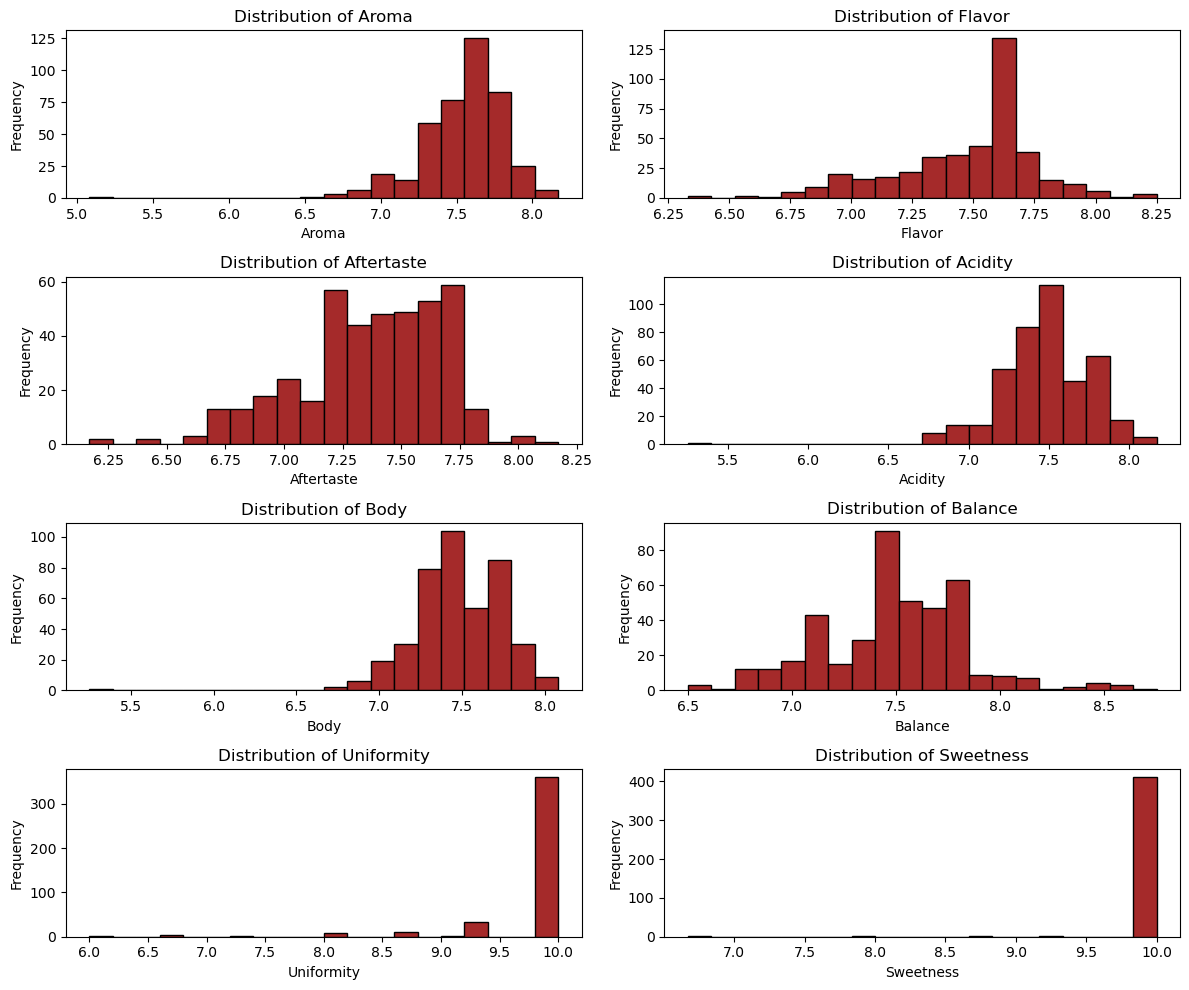

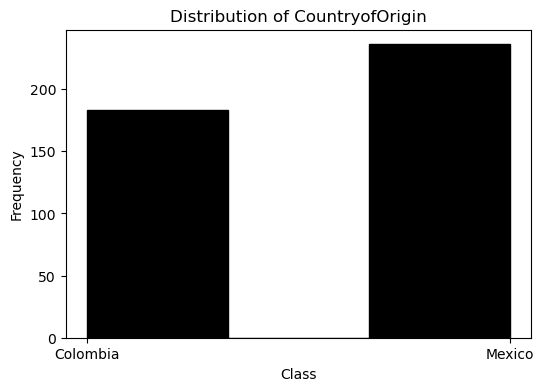

In [56]:
# Visualization of the coffee data

# Show the distribution of the features:
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(4, 2, i+1) 
    plt.hist(X[:, i], bins=20, color='brown', edgecolor='black')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Show the distribution of the targets:
plt.figure(figsize=(6, 4))
plt.hist(y, bins=3, color='black', edgecolor='black')
plt.title(f"Distribution of {target_name}")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["Colombia", "Mexico"])
plt.show()

In [47]:
#Splitting the data into test and (validation and training)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True)

# Use k fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

## Tuning and testing my decision tree on coffee data:

In [48]:
# Find best values for hyperparameters for my own decision tree classifier
best_hyperparameters_for_decisionTree = tune_decision_tree("DecisionTree", X_train_val, y_train_val, max_depth_params, criterion, max_features, kf)

print(best_hyperparameters_for_decisionTree)

print(f"The best average accuracy is {best_hyperparameters_for_decisionTree[0]} with Max_depth: {best_hyperparameters_for_decisionTree[1]}, Criterion: {best_hyperparameters_for_decisionTree[2]}, Max_features: {best_hyperparameters_for_decisionTree[3]}.\n")

[np.float64(0.7405026300409119), 3, 'gini', None]
The best average accuracy is 0.7405026300409119 with Max_depth: 3, Criterion: gini, Max_features: None.



In [49]:
# Testing my DecisionTree with the the hyperparameters

rf = DecisionTree(max_depth=best_hyperparameters_for_decisionTree[1], criterion=best_hyperparameters_for_decisionTree[2], max_features=best_hyperparameters_for_decisionTree[3], seed=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")



Training and validation accuracy: 0.7713310580204779
Test accuracy: 0.746031746031746


## Tuning and testing my random forest on coffee data:

In [50]:
# Find best values for hyperparameters for my own random forest classifier

best_hypermeters_random_forest = tune_random_forest("RandomForest",X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf)


print(best_hypermeters_random_forest)

print(f"The best average accuracy is {best_hypermeters_random_forest[0]} with N_estimators: {best_hypermeters_random_forest[1]}, Max_depth: {best_hypermeters_random_forest[2]}, Criterion: {best_hypermeters_random_forest[3]}, Max_features: {best_hypermeters_random_forest[4]}.\n")


[np.float64(0.8572764465225013), 2, 15, 'entropy', None]
The best average accuracy is 0.8572764465225013 with N_estimators: 2, Max_depth: 15, Criterion: entropy, Max_features: None.



In [51]:
# Testing the hyperparameters on test set with my own random forest classifier

rf = RandomForest(n_estimators=best_hypermeters_random_forest[1], max_depth=best_hypermeters_random_forest[2], criterion=best_hypermeters_random_forest[3], max_features=best_hypermeters_random_forest[4], seed=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9078498293515358
Test accuracy: 0.7380952380952381


### Comparing coffee data with wine, and coffee random forest and decision tree

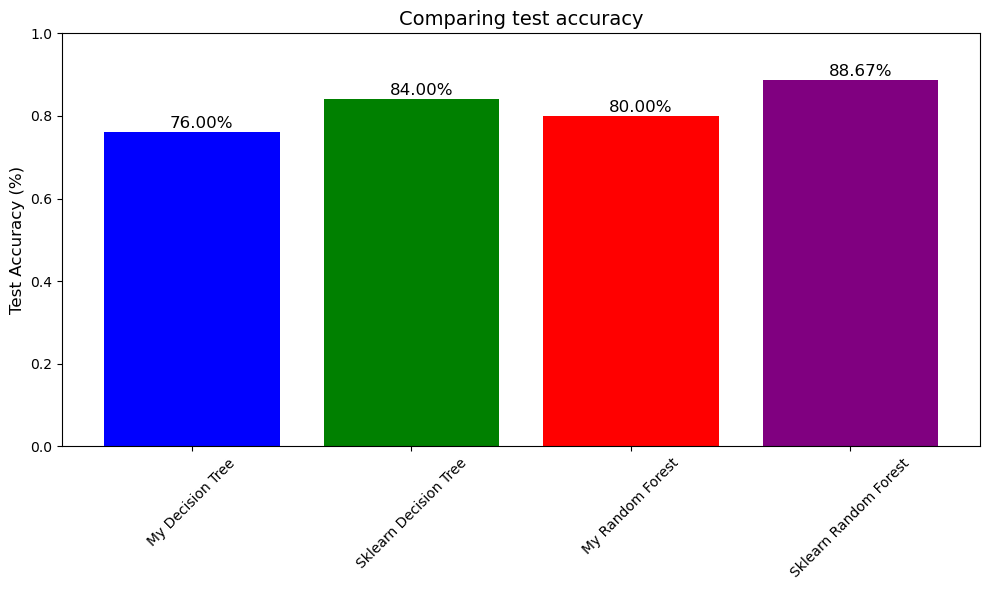

In [52]:
# Data for the classifiers and their test accuracies
classifiers = ['My Decision Tree', 'Sklearn Decision Tree', 'My Random Forest', 'Sklearn Random Forest']
test_accuracies = [0.76, 0.84, 0.8, 0.8866666666666667]

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_colors = ['blue', 'green', 'red', 'purple']  # Different colors for each bar
bars = plt.bar(classifiers, test_accuracies, color=bar_colors)

# Add the accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.01, f"{yval:.2%}", fontsize=12)  # Convert to percentage format

# Customize the plot
plt.title('Comparing test accuracy', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.ylim(0, 1.0)  # Set y-axis limits from 0 to 100% (0 to 1.0)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

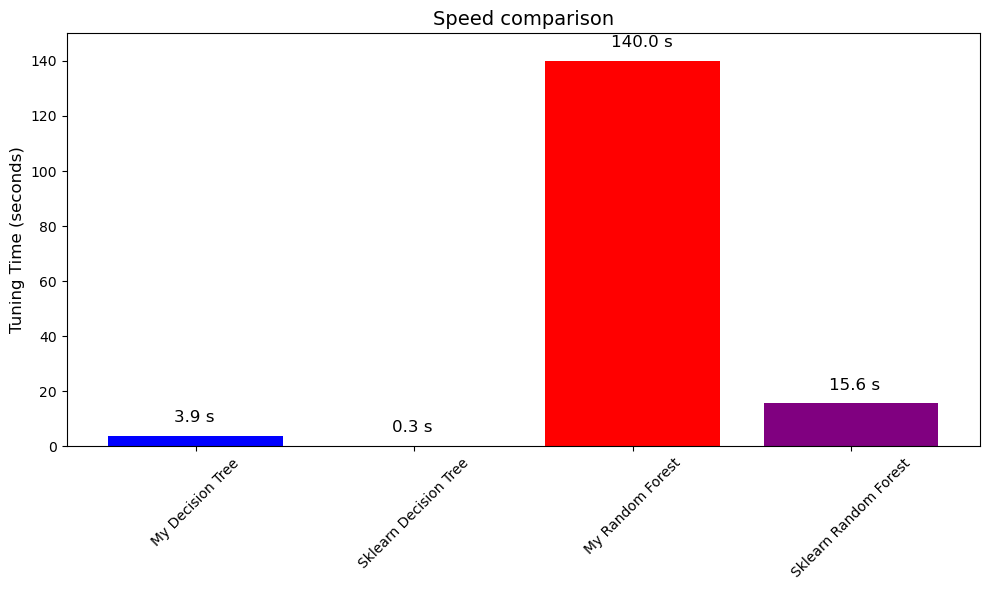

In [53]:
# Data for the classifiers and their tuning times in seconds
classifiers = ['My Decision Tree', 'Sklearn Decision Tree', 'My Random Forest', 'Sklearn Random Forest']
tuning_times = [3.9, 0.3, 140, 15.6]  # Times in seconds (2m 20s is 140 seconds)

# Create the bar plot for tuning times
plt.figure(figsize=(10, 6))
bar_colors = ['blue', 'green', 'red', 'purple']  # Different colors for each bar
bars = plt.bar(classifiers, tuning_times, color=bar_colors)

# Add the tuning time values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 5, f"{yval:.1f} s", fontsize=12)  # Show time in seconds

# Customize the plot
plt.title('Speed comparison', fontsize=14)
plt.ylabel('Tuning Time (seconds)', fontsize=12)
plt.ylim(0, 150)  # Set y-axis limits for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

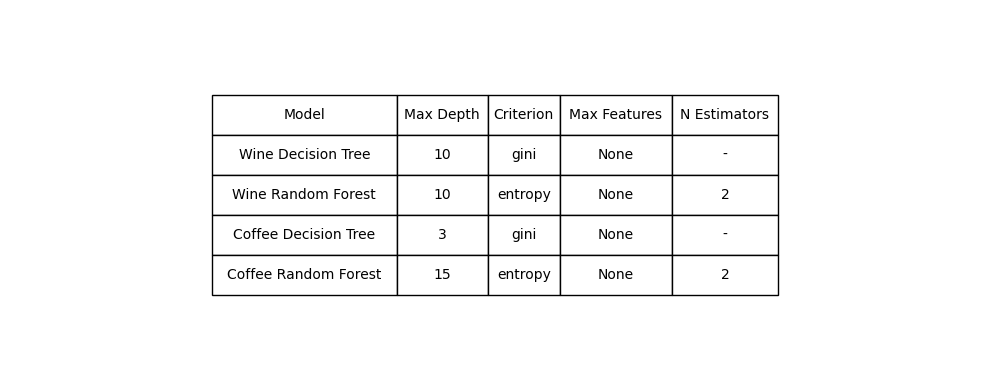

In [54]:
# Data for the table (rows for each dataset-model pair)
data = [
    ['Wine Decision Tree', 10, 'gini', 'None', "-"],
    ['Wine Random Forest', 10, 'entropy', 'None', 2],
    ['Coffee Decision Tree', 3, 'gini', 'None', "-"],
    ['Coffee Random Forest', 15, 'entropy', 'None', 2]
]

# Column labels
columns = ['Model', 'Max Depth', 'Criterion', 'Max Features', 'N Estimators']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Hide the axis
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=data, colLabels=columns, cellLoc='center', loc='center')

# Adjust the table's scale for better fit
table.scale(1, 2)

# Set the font size and enable auto-fitting
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column widths
table.auto_set_column_width([0, 1, 2, 3, 4])

# Show the plot
plt.tight_layout()
plt.show()